### Fix Data

In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
#importing the data 
df_actual = pd.read_csv('UTMSBA_ACTL.csv')
df_schd = pd.read_csv('UTMSBA_SCHD.csv')
df1 = df_actual.copy()
df2 = df_schd.copy()

In [4]:
#Added cols
df1['pairs'] = df1['Orig'] + ' - ' + df1['Dest']

In [5]:
#Dates
def date_format(value):
    value = str(value)
    year = int(value[:4])
    month = int(value[5:7])
    day = int(value[8:])
    
    #print(year,month,day)
    date = datetime.date(year,month, day)
    return date 

df1['Dep_dt'] = df1['Dep_dt'].map(date_format)
df1['day_of_week'] = df1['Dep_dt'].apply(lambda x: dt.weekday(x))

#year_month
def year_month(value):
    value = str(value)
    return str(value[:7])

df1['year_month'] = df1['Dep_dt'].map(year_month)

In [6]:
#Arrival time
def hour_of_the_day(time):
    time = str(time)
    return int(time[:-2])

df1['hour_out'] = df1['ACTL_TM_OUT_CENT'].map(hour_of_the_day)
df1['hour_in'] = df1['ACTL_TM_IN_CENT'].map(hour_of_the_day)

In [7]:
#Pull out month
def pull_month(value):
    value = str(value)
    month = int(value[5:7])
    return month

df1['month'] = df1['Dep_dt'].map(pull_month)

In [8]:
#Pull out year
def pull_year(value):
    value = str(value)
    year = int(value[:4])
    return year

df1['year'] = df1['Dep_dt'].map(pull_year)

In [9]:
#Name day of week
import calendar
days = list(calendar.day_abbr)
def name_day(value): 
    return days[value]

df1['day'] = df1['day_of_week'].map(name_day)

In [10]:
#create weeks
df1['Dep_dt'][0].strftime('%W') #first week = 35th week of the year
df1['week_of_year'] = df1['Dep_dt'].apply(lambda x: x.strftime('%W'))

In [11]:
df1.head()

,Dep_dt,Orig,Dest,Tail,Stage_length,ACTL_TM_IN_CENT,ACTL_TM_OUT_CENT,ACFT,Actl_BM,Gross_gal,...,Tanker_gal,pairs,day_of_week,year_month,hour_out,hour_in,month,year,day,week_of_year
0,2017-09-01,FYX,ZEY,N09303,240,1005,844,73W,81,536.3,...,0.0,FYX - ZEY,4,2017-09,8,10,9,2017,Fri,35
1,2017-09-01,ZEY,KMU,N09303,274,1139,1043,73W,56,1145.6,...,0.0,ZEY - KMU,4,2017-09,10,11,9,2017,Fri,35
2,2017-09-01,KMU,DWF,N09303,1419,1520,1221,73W,179,1923.3,...,0.0,KMU - DWF,4,2017-09,12,15,9,2017,Fri,35
3,2017-09-01,DWF,ZEY,N09303,1213,1838,1556,73W,162,2115.7,...,0.0,DWF - ZEY,4,2017-09,15,18,9,2017,Fri,35
4,2017-09-01,ZEY,FSG,N09303,1051,2140,1925,73W,135,2703.5,...,1029.7,ZEY - FSG,4,2017-09,19,21,9,2017,Fri,35


In [12]:
df1.columns.values

array(['Dep_dt', 'Orig', 'Dest', 'Tail', 'Stage_length',
       'ACTL_TM_IN_CENT', 'ACTL_TM_OUT_CENT', 'ACFT', 'Actl_BM',
       'Gross_gal', 'Enroute_gal', 'Alt_gal', 'Cont_gal', 'Tanker_gal',
       'pairs', 'day_of_week', 'year_month', 'hour_out', 'hour_in',
       'month', 'year', 'day', 'week_of_year'], dtype=object)

In [16]:
df2.head()

,Dep_dt,Orig,Dest,Stage_length,ACFT,Schd_BM,OPNG_RTE_ID,OPNG_RTE_SEG_ID,TM_OUT_mins
0,2017-01-01,ZMB,AIJ,767,733,140,1,0,360
1,2017-01-01,AIJ,LSV,252,733,60,1,1,545
2,2017-01-01,LSV,PUS,482,733,95,1,2,640
3,2017-01-01,PUS,KHG,321,733,60,1,3,770
4,2017-01-01,KHG,PUS,321,733,75,1,4,865


In [17]:
#Drop time > 27 and airports with only one flight
df1_new = df1.drop(df1[df1['hour_out']>27].index,axis=0)

In [18]:
a = df1_new['Orig'].value_counts()==1
drps = list(a[a].index)

In [19]:
df1_f = df1_new.drop(df1_new[df1_new['Orig'].isin(drps)].index,axis=0)

### Clustering

In [17]:
#cluster using the data in df1_f
from sklearn.cluster import MiniBatchKMeans

In [18]:
#group airports and sum
for_clust_sum = df1_f.groupby(['Orig'])[[ 'Actl_BM', 'Gross_gal', 'Enroute_gal',
       'Alt_gal', 'Cont_gal', 'Tanker_gal']].sum() 

In [19]:
#group airports and calc mean values
for_clust_mean = df1_f.groupby(['Orig'])[[ 'Actl_BM', 'Gross_gal', 'Enroute_gal',
       'Alt_gal', 'Cont_gal', 'Tanker_gal']].mean()

In [20]:
#group airports and calc median
for_clust_med = df1_f.groupby(['Orig'])[[ 'Actl_BM', 'Gross_gal', 'Enroute_gal',
       'Alt_gal', 'Cont_gal', 'Tanker_gal']].median()

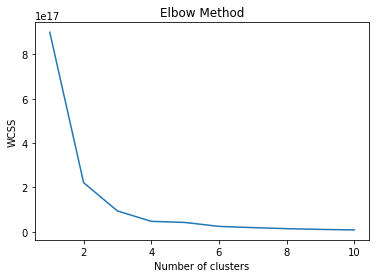

In [21]:
#Elbow plot to choose num of clusters for sum
wcss = []
for i in range(1, 11):
    kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=3, random_state=0)
    kmeans.fit(for_clust_sum)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

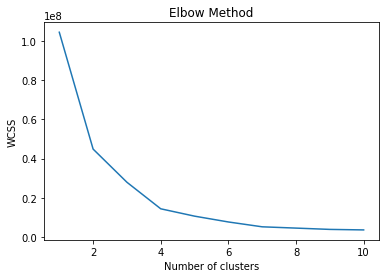

In [22]:
#Elbow plot to choose num of clusters for mean
wcss = []
for i in range(1, 11):
    kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=3, random_state=0)
    kmeans.fit(for_clust_mean)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

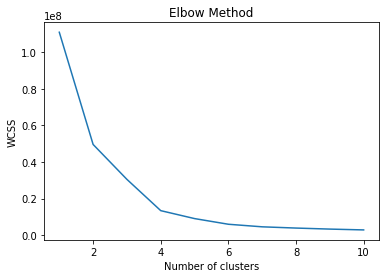

In [23]:
#Elbow plot to choose num of clusters for median
wcss = []
for i in range(1, 11):
    kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=3, random_state=0)
    kmeans.fit(for_clust_med)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [24]:
#create clusters using mean
mean_clusters = MiniBatchKMeans(n_clusters=7, init_size=1024, batch_size=2048, random_state=20).fit_predict(for_clust_mean)
for_clust_mean['cluster'] = pd.Series(mean_clusters, index=for_clust_mean.index)

In [25]:
#create clusters using sum
sum_clusters = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(for_clust_sum)
for_clust_sum['cluster'] = pd.Series(sum_clusters, index=for_clust_sum.index)

In [26]:
#for_clust_mean.head()

,Actl_BM,Gross_gal,Enroute_gal,Alt_gal,Cont_gal,Tanker_gal,cluster
Orig,,,,,,,
AIB,145.216200,1841.370053,1316.299216,172.086366,237.720610,115.263064,2
AIJ,113.387798,1609.180129,960.660872,163.734451,233.721683,251.062662,6
API,51.500000,0.000000,0.000000,0.000000,0.000000,0.000000,5
AQL,101.148754,1018.794120,517.363476,183.866769,213.572566,103.991592,4
AUT,125.396993,1367.159426,928.520601,169.960983,222.344091,46.330995,6


In [27]:
#for_clust_sum.head()

,Actl_BM,Gross_gal,Enroute_gal,Alt_gal,Cont_gal,Tanker_gal,cluster
Orig,,,,,,,
AIB,14172375,179708510.3,128464222,16794768.9,23200342.9,11249098.7,3
AIJ,17310008,245660656.9,146656410,24996028.8,35680419.6,38327728.1,1
API,103,0.0,0,0.0,0.0,0.0,2
AQL,860169,8663825.2,4399659,1563603.0,1816221.1,884344.5,2
AUT,1892993,20638638.7,14016947,2565731.0,3356506.4,699412.7,2


In [28]:
for_clust_mean['cluster'].value_counts()

4    25
2    25
6    24
0    24
5    16
1    11
3     1
Name: cluster, dtype: int64

In [29]:
for_clust_sum['cluster'].value_counts()

2    87
0    22
3    10
1     7
Name: cluster, dtype: int64

Choose to continue with for_clust_mean with 7 clusters bc more evenly distributed

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

In [33]:
#agglomerative cluster - euclidean
agg_clusters_e = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward').fit_predict(for_clust_mean)
for_clust_mean['cluster_euclid'] = pd.Series(agg_clusters_e, index=for_clust_mean.index)

In [35]:
#agglomerative cluster - cosine
agg_clusters_c = AgglomerativeClustering(n_clusters=7, affinity='cosine', linkage='single').fit_predict(for_clust_mean)
for_clust_mean['cluster_cosine'] = pd.Series(agg_clusters_c, index=for_clust_mean.index)

In [36]:
#for_clust_mean.head()

,Actl_BM,Gross_gal,Enroute_gal,Alt_gal,Cont_gal,Tanker_gal,cluster,cluster_euclid,cluster_cosine
Orig,,,,,,,,,
AIB,145.216200,1841.370053,1316.299216,172.086366,237.720610,115.263064,2,0,0
AIJ,113.387798,1609.180129,960.660872,163.734451,233.721683,251.062662,6,0,0
API,51.500000,0.000000,0.000000,0.000000,0.000000,0.000000,5,4,1
AQL,101.148754,1018.794120,517.363476,183.866769,213.572566,103.991592,4,3,0
AUT,125.396993,1367.159426,928.520601,169.960983,222.344091,46.330995,6,1,0


In [38]:
for_clust_mean['cluster_euclid'].value_counts()

1    34
0    31
3    19
4    16
6    15
2    10
5     1
Name: cluster_euclid, dtype: int64

In [39]:
for_clust_mean['cluster_cosine'].value_counts()

0    116
1      5
6      1
5      1
4      1
3      1
2      1
Name: cluster_cosine, dtype: int64

In [37]:
#to csv
for_clust_mean.to_csv("Mean Clusts_Agg.csv")

### LightGBM

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from subprocess import check_output
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm
#import xgboost as xgb
import lightgbm as lgb

#import warnings
#warnings.filterwarnings("ignore")

#### Prep data

In [21]:
clusters = pd.read_csv("Mean Clusts_Agg.csv")

In [34]:
clusters = clusters.drop(['Actl_BM','Gross_gal','Enroute_gal','Alt_gal','Cont_gal','Tanker_gal'],axis = 1)

In [29]:
#creating columns to match Aifaz
df1_f['Dep_dt']= pd.to_datetime(df1['Dep_dt']) 
df1_f['year'] = df1['Dep_dt'].dt.year
df1_f['day_of_year'] = df1['Dep_dt'].dt.dayofyear
#df1['weekday'] = df1['Dep_dt'].dt.weekday
#df1['week_of_year'] = df1['Dep_dt'].dt.week
df1_f['day_of_month'] = df1['Dep_dt'].dt.day
df1_f['quarter'] = df1['Dep_dt'].dt.quarter
#df1.drop('activation_date', axis=1, inplace=True)

In [30]:
df1_f.columns

Index(['Dep_dt', 'Orig', 'Dest', 'Tail', 'Stage_length', 'ACTL_TM_IN_CENT',
       'ACTL_TM_OUT_CENT', 'ACFT', 'Actl_BM', 'Gross_gal', 'Enroute_gal',
       'Alt_gal', 'Cont_gal', 'Tanker_gal', 'pairs', 'day_of_week',
       'year_month', 'hour_out', 'hour_in', 'month', 'year', 'day',
       'week_of_year', 'day_of_year', 'day_of_month', 'quarter'],
      dtype='object')

In [31]:
df1_f = df1_f.drop('day',axis=1)

In [36]:
#merge with clusters file
df1_wc = df1_f.merge(clusters, how='left',on='Orig')

In [39]:
df1_wc.head()

,Dep_dt,Orig,Dest,Tail,Stage_length,ACTL_TM_IN_CENT,ACTL_TM_OUT_CENT,ACFT,Actl_BM,Gross_gal,...,hour_in,month,year,week_of_year,day_of_year,day_of_month,quarter,cluster,cluster_euclid,cluster_cosine
0,2017-09-01,FYX,ZEY,N09303,240,1005,844,73W,81,536.3,...,10,9,2017,35,244,1,3,4,3,0
1,2017-09-01,ZEY,KMU,N09303,274,1139,1043,73W,56,1145.6,...,11,9,2017,35,244,1,3,2,0,0
2,2017-09-01,KMU,DWF,N09303,1419,1520,1221,73W,179,1923.3,...,15,9,2017,35,244,1,3,6,1,0
3,2017-09-01,DWF,ZEY,N09303,1213,1838,1556,73W,162,2115.7,...,18,9,2017,35,244,1,3,6,1,0
4,2017-09-01,ZEY,FSG,N09303,1051,2140,1925,73W,135,2703.5,...,21,9,2017,35,244,1,3,2,0,0


#### Run lightgbm

In [41]:
#keep only the cluster type that you want to use - here we will use kmeans cluster ouput 'cluster' 
#drop the euclid and cosine clusters
df1_gbm = df1_wc.drop(['cluster_euclid','cluster_cosine'], axis=1)
df1_gbm.columns

In [43]:
df1_gbm.columns

Index(['Dep_dt', 'Orig', 'Dest', 'Tail', 'Stage_length', 'ACTL_TM_IN_CENT',
       'ACTL_TM_OUT_CENT', 'ACFT', 'Actl_BM', 'Gross_gal', 'Enroute_gal',
       'Alt_gal', 'Cont_gal', 'Tanker_gal', 'pairs', 'day_of_week',
       'year_month', 'hour_out', 'hour_in', 'month', 'year', 'week_of_year',
       'day_of_year', 'day_of_month', 'quarter', 'cluster'],
      dtype='object')

In [46]:
cat_columns = df1_gbm.dtypes[df1_gbm.dtypes == 'object'].index
cat_columns

Index(['Orig', 'Dest', 'Tail', 'ACFT', 'pairs', 'year_month', 'week_of_year'], dtype='object')

In [47]:
#encode and fill any NAs
label_encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    df1_gbm[col].fillna("unknown")
    df1_gbm[col] = label_encoder.fit_transform(df1_gbm[col].astype(str))

In [81]:
#Model by cluster (0)
grp = df1_gbm[df1_gbm['cluster'] == 0]
grp = grp[grp.Gross_gal.between(grp.Gross_gal.quantile(.000), grp.Gross_gal.quantile(.95))] # without outliers

X = grp.drop(['Dep_dt','Gross_gal', 'Enroute_gal','Alt_gal', 'Cont_gal', 'Tanker_gal', 'pairs','ACTL_TM_IN_CENT',
       'ACTL_TM_OUT_CENT','Actl_BM'], axis=1)
y = grp.Gross_gal
feature_names = X.columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)
    
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names,
                categorical_feature = cat_columns)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=feature_names,
                categorical_feature = cat_columns)

params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 40,
    'max_depth': 20,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1,
    'num_iterations': 20000
}
lgb_clf = lgb.train(
    params,
    lgtrain,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=500,
    verbose_eval=500
)
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_valid, lgb_clf.predict(X_valid))))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [66]:
len(grp)

164716

In [67]:
len(df1_gbm[(df1_gbm['cluster'] == 0)])

173386

In [73]:
feature_names

['Orig',
 'Dest',
 'Tail',
 'Stage_length',
 'ACFT',
 'day_of_week',
 'year_month',
 'hour_out',
 'hour_in',
 'month',
 'year',
 'week_of_year',
 'day_of_year',
 'day_of_month',
 'quarter',
 'cluster']

In [78]:
cat_columns

Index(['Orig', 'Dest', 'Tail', 'ACFT', 'pairs', 'year_month', 'week_of_year'], dtype='object')

In [79]:
cat_columns.tolist()

['Orig', 'Dest', 'Tail', 'ACFT', 'pairs', 'year_month', 'week_of_year']

In [87]:
lgtrain